<a href="https://colab.research.google.com/github/sam134-eng/INM706-Sequence-analysis/blob/main/TF_IDF_%2B_Logistic_Regression_in_PyTorch_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Ensure NLTK data is downloaded ---
# Calling nltk.download() directly without checking for existence first,
# as the downloader itself handles whether the resource is already present.
# Setting quiet=False to show download progress.
print("Ensuring 'punkt' NLTK resource is downloaded...")
nltk.download('punkt', quiet=False)
print("Ensuring 'stopwords' NLTK resource is downloaded...")
nltk.download('stopwords', quiet=False)
# Add the download for 'punkt_tab' as suggested by the error
print("Ensuring 'punkt_tab' NLTK resource is downloaded...")
nltk.download('punkt_tab', quiet=False)


# --- 1. Load and Preprocess Data ---
# Assuming 'Tweets.csv' is available in the environment.
# In a Colab environment, you would typically upload it first.
# For this self-contained code, we'll assume it's loaded.
# If running locally, ensure 'Tweets.csv' is in the same directory.
try:
    df = pd.read_csv("Tweets.csv")
except FileNotFoundError:
    print("Error: 'Tweets.csv' not found. Please ensure the file is uploaded or in the correct directory.")
    # Create a dummy DataFrame for demonstration if file is not found
    data = {
        'text': [
            "@VirginAmerica What @dhepburn said.",
            "@VirginAmerica plus you've added commercials to the experience... #fail",
            "@VirginAmerica I didn't today... Must mean I need to fly it again!",
            "@VirginAmerica it's really aggressive to blast obnoxious "
            "loud commercials into little earbuds. #anditshardtohearanyone",
            "@VirginAmerica and it's a really big bad thing about it"
        ],
        'airline_sentiment': ['neutral', 'negative', 'positive', 'negative', 'negative']
    }
    df = pd.DataFrame(data)
    print("Using a dummy DataFrame for demonstration.")


# Keep only relevant columns: 'text' and 'airline_sentiment'
df = df[['text', 'airline_sentiment']]

# Filter to ensure only 'positive', 'neutral', 'negative' sentiments are included
df = df[df['airline_sentiment'].isin(['positive', 'neutral', 'negative'])]

# Map sentiment labels to integers for model training
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_map)

# Define stopwords for text cleaning
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text
def clean_text(text):
    """
    Cleans the input text by:
    - Removing URLs, mentions (@), hashtags (#)
    - Removing non-alphabetic characters
    - Converting to lowercase
    - Tokenizing the text
    - Removing stopwords
    """
    text = re.sub(r"http\S+|@\w+|#\w+|[^a-zA-Z\s]", "", text.lower())
    # word_tokenize relies on the 'punkt' tokenizer data
    tokens = word_tokenize(text)
    return " ".join([t for t in tokens if t not in stop_words]) # Join tokens back to string for TF-IDF

# Apply the cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# --- 2. Prepare Data for TF-IDF Vectorization ---
X = df['clean_text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
# max_features: limits the number of features (vocabulary size)
vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on training data and transform both training and test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert sparse TF-IDF matrices to dense NumPy arrays, then to PyTorch Tensors
# PyTorch's nn.Linear layer typically expects dense inputs.
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Convert labels to PyTorch LongTensors (required for nn.CrossEntropyLoss)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets and DataLoaders for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64 # Define batch size for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 3. Define PyTorch Logistic Regression Model ---
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        # Define a single linear layer for logistic regression
        # input_dim: number of features from TF-IDF (max_features)
        # num_classes: number of sentiment categories (3: negative, neutral, positive)
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Forward pass: apply the linear transformation
        # nn.CrossEntropyLoss will apply softmax internally, so no explicit softmax here
        return self.linear(x)

# Get input dimension (number of features from TF-IDF)
input_dim = X_train_tensor.shape[1]
num_classes = len(label_map) # Number of unique sentiment classes

# Instantiate the model
model = LogisticRegressionModel(input_dim, num_classes)

# --- 4. Define Loss Function and Optimizer ---
# CrossEntropyLoss is suitable for multi-class classification
# It combines LogSoftmax and NLLLoss (Negative Log Likelihood Loss)
criterion = nn.CrossEntropyLoss()

# Adam optimizer is a good general-purpose optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate can be tuned

# --- 5. Train the Model ---
num_epochs = 10 # Number of training epochs

print("\n--- Starting PyTorch Model Training ---")
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("\n--- Training Complete ---")

# --- 6. Evaluate the Model ---
model.eval() # Set the model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Get the predicted class (index of the max log-probability)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("\nTF-IDF + PyTorch Logistic Regression Performance:")
print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive']))

Ensuring 'punkt' NLTK resource is downloaded...
Ensuring 'stopwords' NLTK resource is downloaded...
Ensuring 'punkt_tab' NLTK resource is downloaded...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



--- Starting PyTorch Model Training ---
Epoch [1/10], Loss: 0.9998
Epoch [2/10], Loss: 0.8716
Epoch [3/10], Loss: 0.8068
Epoch [4/10], Loss: 0.7655
Epoch [5/10], Loss: 0.7328
Epoch [6/10], Loss: 0.7042
Epoch [7/10], Loss: 0.6786
Epoch [8/10], Loss: 0.6552
Epoch [9/10], Loss: 0.6339
Epoch [10/10], Loss: 0.6144

--- Training Complete ---

TF-IDF + PyTorch Logistic Regression Performance:
              precision    recall  f1-score   support

    Negative       0.70      0.99      0.82      1835
     Neutral       0.78      0.20      0.31       620
    Positive       0.89      0.32      0.46       473

    accuracy                           0.72      2928
   macro avg       0.79      0.50      0.53      2928
weighted avg       0.75      0.72      0.66      2928




Confusion Matrix:
[[1825    7    3]
 [ 483  121   16]
 [ 296   28  149]]


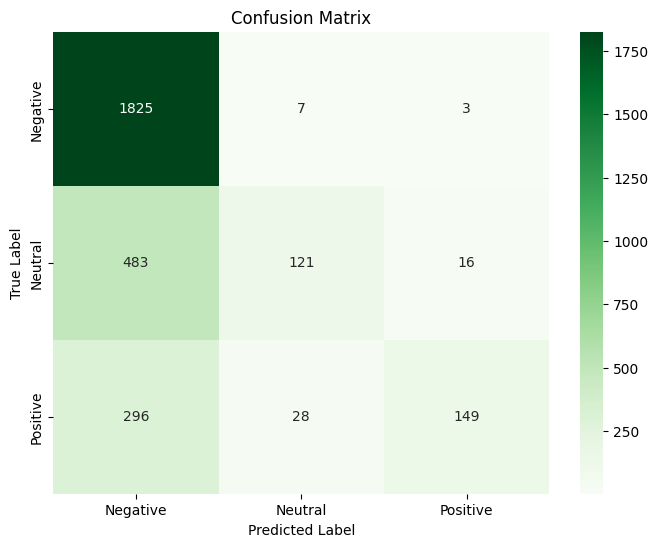

In [4]:
# prompt: generate accuracy/loss plots
# generate classification report
#  generate confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
